<a href="https://colab.research.google.com/github/Renan-LS/Renan-LS/blob/main/cred_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descrição das Features:

 ● idade: A idade do cliente

 ● numero_de_dependentes: O número de pessoas dependentes do cliente.

 ● salario_mensal: Salário mensal do cliente.

 ● numero_emprestimos_imobiliarios: Quantidade de empréstimos imobiliários que o cliente possui em aberto.

 ● util_linhas_inseguras: Quanto que o cliente está usando, relativamente ao limite dele, 
de linhas de crédito que não são seguradas por qualquer bem do tomador e.g: imoveis, carros etc.

 ● vezes_passou_de_30_59_dias: Número de vezes que o cliente atrasou, entre 30 e 59 dias, o pagamento de um empréstimo.
 ● numero_de_vezes_que_passou_60_89_dias: Número de vezes que o cliente atrasou, entre 60 e 89 dias, o pagamento de um empréstimo
 ● numero_vezes_passou_90_dias: Número de vezes que o tomador passou mais de 90 dias em atraso.

 ● razao_debito: Razão entre as dívidas e o patrimônio do tomador. razão débito = Dividas/Patrimônio

 ● numero_linhas_crdto_aberto: Número de empréstimos em aberto pelo cliente.


 ● Saída: 1 - Inadimplente / 0 - Adimplente

Tratamentos exigidos:
- Coluna idade com registros = 0 (deletados devido a qtde ser relativamente baixa)
- Coluna numero_de_dependentes com valores NaN (deletados devido a qtde ser relativamente baixa)



-- CONTINUAR DAQUI
  -> Dados desbalanceados : utilizar modelos que trabalham melhor com eles
  -> Outliers.? Resolvi eliminar somente absurdo (idade = 0) e valores NaN
  ->STARDARTIZATION escolhido para reescalonar os dados
  


In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn as sk
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
import pickle


## Pré-Processamento

In [26]:
cred_score_train = pd.read_csv('/content/treino.csv')


In [27]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
cred_score_train.info()

In [ ]:
cred_score_train.describe()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,"107,121.00","107,121.00","107,121.00","107,121.00","107,121.00","107,121.00","107,121.00","107,121.00","107,121.00","107,121.00","107,121.00"
mean,0.07,5.74,52.05,0.41,335.09,"6,419.27",8.52,0.25,1.03,0.23,0.76
std,0.25,251.79,14.59,4.04,"1,945.54","12,156.23",5.14,4.01,1.14,4.00,1.11
min,0.00,0.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.03,41.00,0.00,0.17,"3,820.00",5.00,0.00,0.00,0.00,0.00
50%,0.00,0.16,52.00,0.00,0.36,"5,400.00",8.00,0.00,1.00,0.00,0.00
75%,0.00,0.57,62.00,0.00,0.76,"7,500.00",11.00,0.00,2.00,0.00,1.00
max,1.00,"50,708.00",107.00,98.00,"329,664.00","3,008,750.00",58.00,98.00,54.00,98.00,20.00


In [ ]:
corr = cred_score_train.corr()
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8,annot_kws={'size': 10}, annot=True, fmt='.2f')
#matriz de correlaçao

In [65]:
np.unique(cred_score_train['inadimplente'],return_counts=True) #Verificando a quantidade  de registro que existe na variável INADIMPLENTE
#nota-se claramente que temos uma classe DESBALACEADA 

(array([0, 1]), array([102669,   7331]))

In [ ]:
sns.countplot(x = cred_score_train['inadimplente']); #demostrando de forma gráfica a observação anterior

In [69]:
cred_score_train.isnull().sum() #verificado a existencia de valores nulos gerando anomalias

inadimplente                             0
util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64

In [67]:
cred_score_train.dropna(subset =['numero_de_dependentes'] , inplace = True)
#Dropando os registros cujo o Nº de dependentes é NaN, devido ao tamanho irrelevante 

mediana = cred_score_train['salario_mensal'].median()
cred_score_train['salario_mensal'].fillna(value=mediana, inplace = True)
#Alterando os valores NaN presente em salario_mensal e substituindo-os pela MEDIANA, devido a quantidade elevada de registros,
#preferi NAO dropa-los

In [68]:
cred_score_train.drop(cred_score_train.loc[cred_score_train['idade'] <= 0].index, inplace=True) #dropando esses elementos
#cred_score_train.loc[cred_score_train['idade'] <= 0] #localizando o registros que possuem essa anomalia
#cred_score_train[cred_score_train['idade'] <= 0]
#verificando as idades que são zeradas ou negativas 
#     TÉCNICAS PARA TRATAMENTO DE IDADE ZERADA:
# -Apagar a coluna inteira ( se a anomalia for em grande parte dos registros da tabela)
# -Apagar somente os registros com valores inconsistentes
# -Preencher os valores incosistentes manualmente
# -Preencher os valores faltantes com a media das idades, retirando as inconsistencias antes

In [ ]:
graf = px.scatter_matrix(cred_score_train,dimensions=['idade'])
graf.show()
#Verificado que existem amostras com idade = 0

In [ ]:
#cred_score['idade'][cred_score['idade'] > 0].mean() #media de idade, desconsiderando os valores nulos na coluna idade

In [ ]:
#graf = px.scatter_matrix(cred_score_train,dimensions=['idade','salario_mensal','razao_debito'],color='inadimplente')
#graf.show()

In [ ]:
grafico = px.box(cred_score_train,y='numero_emprestimos_imobiliarios')
grafico.show()

In [ ]:
X_cred = cred_score_train.iloc[:,1:11].values
Y_cred = cred_score_train.iloc[:,0].values
#realizada divisão entre previsores e classes 


In [ ]:
scaler_cred = StandardScaler()
X_cred = scaler_cred.fit_transform(X_cred)
#realizado o reescalonamento dos valores(Padronização)

In [ ]:
X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = train_test_split(X_cred, Y_cred, test_size=0.2, random_state = 0)
#realizando a divisão na razão 80/20 entre os dados de treino e teste.

In [ ]:
with open('cred_score_variables.pkl',mode = 'wb') as f:
  pickle.dump([X_cred_train, X_cred_test, Y_cred_train, Y_cred_test],f)
#variáveis de teste e treinamentos salvas em "disco"

## Teste de classificadores

**RANDOM FOREST**

In [ ]:
with open('cred_score_variables.pkl','rb') as f:
  X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = pickle.load(f)

In [ ]:
random_forest_cred = RandomForestClassifier(n_estimators=80,random_state = 0)
random_forest_cred.fit(X_cred_train,Y_cred_train)

RandomForestClassifier(n_estimators=80, random_state=0)

In [ ]:
previews = random_forest_cred.predict(X_cred_test)
previews

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
accuracy_score(Y_cred_test,previews)

0.9339089848308051

In [ ]:
print(classification_report(Y_cred_test,previews))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     19956
           1       0.55      0.19      0.28      1469

    accuracy                           0.93     21425
   macro avg       0.75      0.59      0.62     21425
weighted avg       0.92      0.93      0.92     21425



In [ ]:
cm = ConfusionMatrix(random_forest_cred)
cm.fit(X_cred_train,Y_cred_train)
cm.score(X_cred_test,Y_cred_test)

**DECISION TREE**


In [ ]:
with open('cred_score_variables.pkl','rb') as f:
  X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = pickle.load(f)

In [ ]:
X_cred_train.shape , Y_cred_train.shape

((85696, 10), (85696,))

In [ ]:
tree_cred = DecisionTreeClassifier(random_state = 0)
tree_cred.fit(X_cred_train,Y_cred_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
previews = tree_cred.predict(X_cred_test)


In [ ]:
accuracy_score(Y_cred_test,previews)

0.8968961493582264

In [ ]:
print(classification_report(Y_cred_test,previews))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     19956
           1       0.26      0.28      0.27      1469

    accuracy                           0.90     21425
   macro avg       0.61      0.61      0.61     21425
weighted avg       0.90      0.90      0.90     21425



In [ ]:
cm = ConfusionMatrix(random_forest_cred)
cm.fit(X_cred_train,Y_cred_train)
cm.score(X_cred_test,Y_cred_test)

**LOGISTICAL REGRESSION**

In [ ]:
with open('cred_score_variables.pkl','rb') as f:
  X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = pickle.load(f)

In [ ]:
logistic_cred = LogisticRegression(random_state = 1)
logistic_cred.fit(X_cred_train,Y_cred_train)

LogisticRegression(random_state=1)

In [ ]:
logistic_cred.intercept_

In [ ]:
logistic_cred.coef_

In [ ]:
previews = logistic_cred.predict(X_cred_test)

In [ ]:
accuracy_score(Y_cred_test,previews)

0.9324154025670945

In [ ]:
print(classification_report(Y_cred_test,previews))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     19956
           1       0.61      0.04      0.07      1469

    accuracy                           0.93     21425
   macro avg       0.77      0.52      0.52     21425
weighted avg       0.91      0.93      0.90     21425



In [ ]:
cm = ConfusionMatrix(random_forest_cred)
cm.fit(X_cred_train,Y_cred_train)
cm.score(X_cred_test,Y_cred_test)

## Tunning de modelos e Validação Cruzada

In [6]:
with open('cred_score_variables.pkl','rb') as f:
  X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = pickle.load(f)

In [7]:
X_cred = np.concatenate((X_cred_train,X_cred_test),axis = 0)
Y_cred = np.concatenate((Y_cred_train,Y_cred_test),axis = 0)
#Concatenando novamente toda base de dados, já padronizada, de modo a ser utilizada na CV

**Random Forest**

In [ ]:
parameters = {'criterion':['gini','entropy'],
              'n_estimators':[10,40,80,100,150],
              'min_samples_split':[2, 5, 10],
              'min_samples_leaf':[1, 5, 10]}

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters)
grid_search.fit(X_cred,Y_cred)
best_parameters = grid_search.best_params_
best_result = grid_search.best_score_
print(best_parameters)
print(best_result)

{'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150}
0.9365670579151789


**Decision Tree**

In [ ]:
parameters = {'criterion':['gini','entropy'],
              'splitter':['best','random'],
              'min_samples_split':[2, 5, 10],
              'min_samples_leaf':[1, 5, 10]}

In [ ]:
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters)
grid_search.fit(X_cred,Y_cred)
best_parameters = grid_search.best_params_
best_result = grid_search.best_score_
print(best_parameters)
print(best_result)

{'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'random'}
0.9338318221072693


**Logistic Regression**

In [4]:
parameters = {'tol':[0.0001, 0.00001, 0.000001],
              'C':[1.0, 1.5, 2.0],
              'solver':['lbfgs','sag','saga']}

In [8]:
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters)
grid_search.fit(X_cred,Y_cred)
best_parameters = grid_search.best_params_
best_result = grid_search.best_score_
print(best_parameters)
print(best_result)

{'C': 2.0, 'solver': 'lbfgs', 'tol': 0.0001}
0.9336357876922727


***Cross Validation***

In [57]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
#utilizado o StratifieldKfold devido ao desbalanceamento das classes de saída,pois ele 

tree = DecisionTreeClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=10, splitter='random')
scores = cross_val_score(tree, X_cred, Y_cred, cv=kfold)
results_tree = scores.mean()

##

random_forest = RandomForestClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=10, n_estimators=150)
scores = cross_val_score(random_forest, X_cred, Y_cred, cv=kfold)
results_random_forest = scores.mean()

##

logistic = LogisticRegression(C=2.0, solver = 'lbfgs', tol = 0.0001)
scores = cross_val_score(logistic, X_cred, Y_cred, cv=kfold)
results_logistic = scores.mean()

In [58]:
results_tree, results_random_forest, results_logistic

(0.9337945269638481, 0.9362590204874872, 0.93363579855622)

De acordo com os testes realizados com CV e GridSearch, confirmamos que o melhor algoritmo a utilzar neste caso é **RANDOM FOREST**

## FINALIZANDO O MODELO

UTILIZANDO CV DEFINIR OS GRUPOS DE TREINAMENTO E DE TEST

In [59]:
random_forest = RandomForestClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=10, n_estimators=150)
random_forest.fit(X_cred,Y_cred)
results_random_forest = cross_val_predict(logistic, X_cred, Y_cred, cv=kfold)
#scores = cross_val_score(logistic, X_cred, Y_cred, cv=kfold)
#results_random_forest_mean = scores.mean()

In [60]:
#print(results_random_forest_mean)
print('\n',accuracy_score(Y_cred, results_random_forest))
print('\n',classification_report(Y_cred, results_random_forest))



 0.9336357950355206

               precision    recall  f1-score   support

           0       0.94      1.00      0.97     99922
           1       0.59      0.04      0.08      7199

    accuracy                           0.93    107121
   macro avg       0.76      0.52      0.52    107121
weighted avg       0.91      0.93      0.91    107121



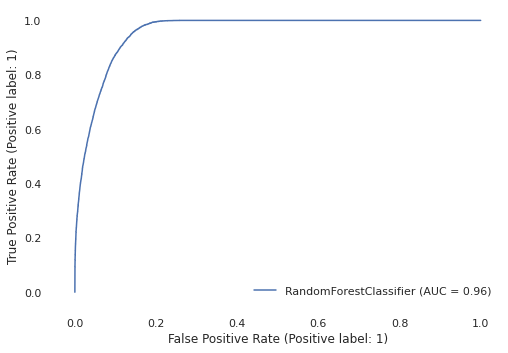

In [61]:
plot_roc_curve(random_forest,X_cred,Y_cred)

UTILIZANDO PROPORCAO 80/20 PARA treino E test, RESPECTIVAMENTE

In [48]:
with open('cred_score_variables.pkl','rb') as f:
  X_cred_train, X_cred_test, Y_cred_train, Y_cred_test = pickle.load(f)

random_forest_cred = RandomForestClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=10, n_estimators=150)
random_forest_cred.fit(X_cred_train,Y_cred_train)

previews = random_forest_cred.predict(X_cred_test)
accuracy_score(Y_cred_test,previews)

0.9345157526254376

In [50]:
print(classification_report(Y_cred_test,previews))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     19956
           1       0.59      0.15      0.24      1469

    accuracy                           0.93     21425
   macro avg       0.76      0.57      0.60     21425
weighted avg       0.92      0.93      0.92     21425



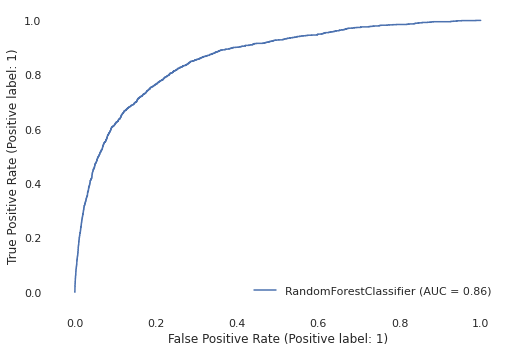

In [53]:
plot_roc_curve(random_forest_cred,X_cred_test,Y_cred_test)

**Testando o modelo com TEST.CSV**


In [89]:
cred_score_teste = pd.read_csv('/content/teste.csv')

In [ ]:
cred_score_teste.describe()

In [93]:
cred_score_teste.isnull().sum()

util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64

In [92]:
cred_score_teste.dropna(subset =['numero_de_dependentes'] , inplace = True)
mediana = cred_score_teste['salario_mensal'].median()
cred_score_teste['salario_mensal'].fillna(value=mediana, inplace = True)

In [ ]:
cred_score_train.describe()

In [95]:
X_cred_teste = cred_score_teste.iloc[:,:].values

In [96]:
scaler_cred = StandardScaler()
X_cred_teste = scaler_cred.fit_transform(X_cred_teste)

In [102]:
previsoes = random_forest_cred.predict(X_cred_teste)

In [103]:
cred_score_teste['inadimplente'] = previsoes

In [104]:
cred_score_teste.describe()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
count,"38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00","38,954.00"
mean,6.42,52.22,0.40,328.65,"6,520.52",8.55,0.24,1.02,0.22,0.76,0.01
std,245.27,14.63,3.90,"1,939.45","15,276.08",5.17,3.87,1.12,3.85,1.12,0.09
min,0.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.03,41.00,0.00,0.17,"3,817.25",5.00,0.00,0.00,0.00,0.00,0.00
50%,0.15,52.00,0.00,0.36,"5,409.50",8.00,0.00,1.00,0.00,0.00,0.00
75%,0.56,62.00,0.00,0.77,"7,500.00",11.00,0.00,2.00,0.00,1.00,0.00
max,"22,000.00",103.00,98.00,"307,001.00","1,794,060.00",57.00,98.00,25.00,98.00,13.00,1.00


In [105]:
np.unique(cred_score_teste['inadimplente'],return_counts=True)

(array([0, 1]), array([38611,   343]))